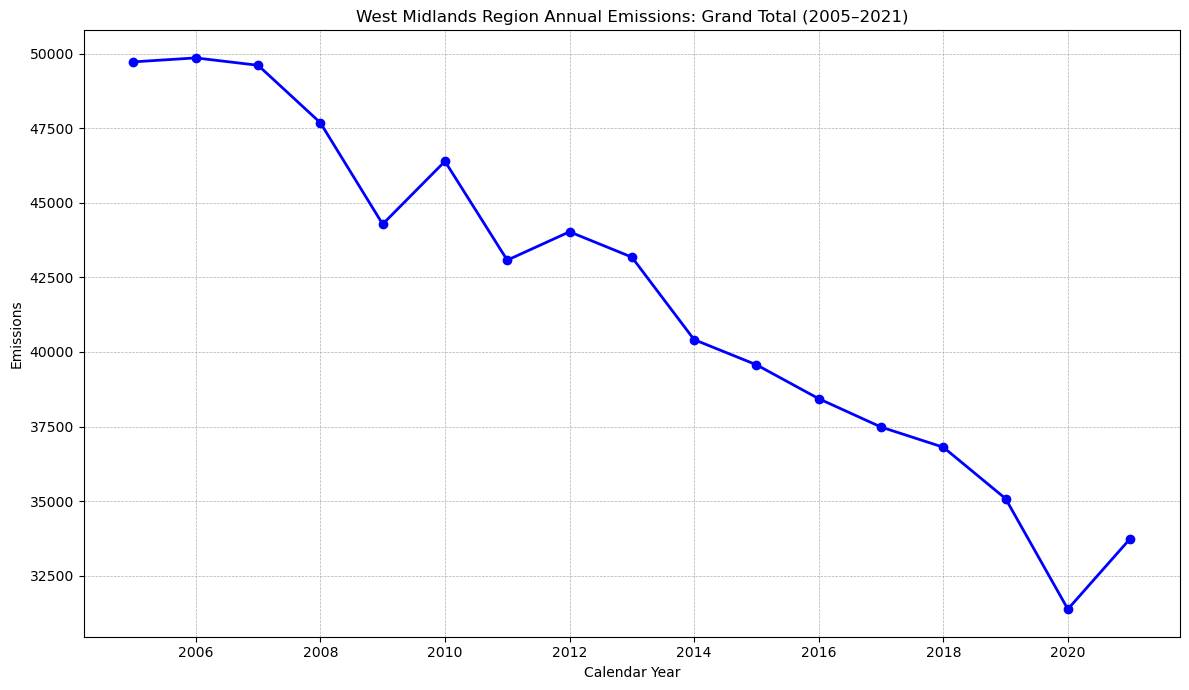

In [7]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

# Read the data
df = pd.read_csv('west_midlands_filtered_columns.csv')

# Group by 'Calendar Year' and sum the "Grand Total" values for each year
grouped_data = df.groupby('Calendar Year')['Grand Total'].sum()

# Plot the summed values for each year
plt.figure(figsize=(12, 7))
grouped_data.plot(kind='line', marker='o', color='blue', linewidth=2)

plt.title('West Midlands Region Annual Emissions: Grand Total (2005–2021)')
plt.ylabel('Emissions')
plt.xlabel('Calendar Year')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


Modeling the time series data using a GRU. Proceeding with the following steps:

1. Data Preparation:
   - Normalize the data.
   - Transform the time series data into input-output pairs for supervised learning.
2. Define the GRU Model.
3. Compile and Train the Model.
4. Evaluate the Model.
5. Forecasting.

### Data Preparation

For this demonstration, sliding window approach is used where the emissions of the last \( N \) years is used to predict the emissions of the next year. Setting \( N \) to 5 for this example, but it can be adjusted based on the specific needs of the analysis.

Begining by normalizing the data and creating input-output pairs.

The data has been prepared for training:

- Having 9 training samples and 3 testing samples.
- Each training sample has 1 time step and 5 features (i.e., the emissions of the last 5 years).
- The corresponding output is the emission of the next year.

With the data ready, move on to defining the GRU model.

### Define the GRU Model

Defining a simple GRU-based model for this task. The model will consist of:

- An input layer that accepts sequences of 5 past observations.
- A GRU layer with 50 units.
- A dense output layer with a linear activation function to predict the next year's emissions.






In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Define a function to convert time series data into input-output pairs
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # Putting it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(grouped_data.values.reshape(-1, 1))

# Convert time series data into input-output pairs
N = 5  # number of past observations to use for prediction
data = series_to_supervised(scaled_data, n_in=N, n_out=1)
values = data.values

# Split the data into training and testing sets
train_size = int(0.8 * len(values))
train, test = values[:train_size, :], values[train_size:, :]
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]

# Reshape data to 3D [samples, timesteps, features] for GRU
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

X_train.shape, y_train.shape, X_test.shape, y_test.shape


((9, 1, 5), (9,), (3, 1, 5), (3,))

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

# Define the GRU model
model = Sequential()
model.add(GRU(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# Display the model's architecture
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 50)                8550      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 8,601
Trainable params: 8,601
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=1, validation_data=(X_test, y_test), verbose=1, shuffle=False)


Epoch 1/50
9/9 [==============================] - 4s 112ms/step - loss: 0.4204 - val_loss: 0.0111
Epoch 2/50
9/9 [==============================] - 0s 9ms/step - loss: 0.1851 - val_loss: 0.0115
Epoch 3/50
9/9 [==============================] - 0s 9ms/step - loss: 0.0631 - val_loss: 0.0366
Epoch 4/50
9/9 [==============================] - 0s 10ms/step - loss: 0.0198 - val_loss: 0.0646
Epoch 5/50
9/9 [==============================] - 0s 11ms/step - loss: 0.0134 - val_loss: 0.0768
Epoch 6/50
9/9 [==============================] - 0s 9ms/step - loss: 0.0122 - val_loss: 0.0728
Epoch 7/50
9/9 [==============================] - 0s 10ms/step - loss: 0.0095 - val_loss: 0.0634
Epoch 8/50
9/9 [==============================] - 0s 10ms/step - loss: 0.0085 - val_loss: 0.0565
Epoch 9/50
9/9 [==============================] - 0s 9ms/step - loss: 0.0089 - val_loss: 0.0536
Epoch 10/50
9/9 [==============================] - 0s 9ms/step - loss: 0.0093 - val_loss: 0.0532
Epoch 11/50
9/9 [================

In [14]:
# Predict on the test set
y_pred = model.predict(X_test)

1/1 [==============================] - 1s 780ms/step


In [15]:
# Inverse transform the predictions to the original scale
y_pred_original = scaler.inverse_transform(y_pred)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))


In [16]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
print(f"Test RMSE: {rmse}")

Test RMSE: 2547.779326466156


In [17]:
import matplotlib.pyplot as plt

# 1. Training and Validation Loss over Epochs
def plot_training_history(history):
    plt.figure(figsize=(12, 7))
    plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='--', linewidth=2)
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

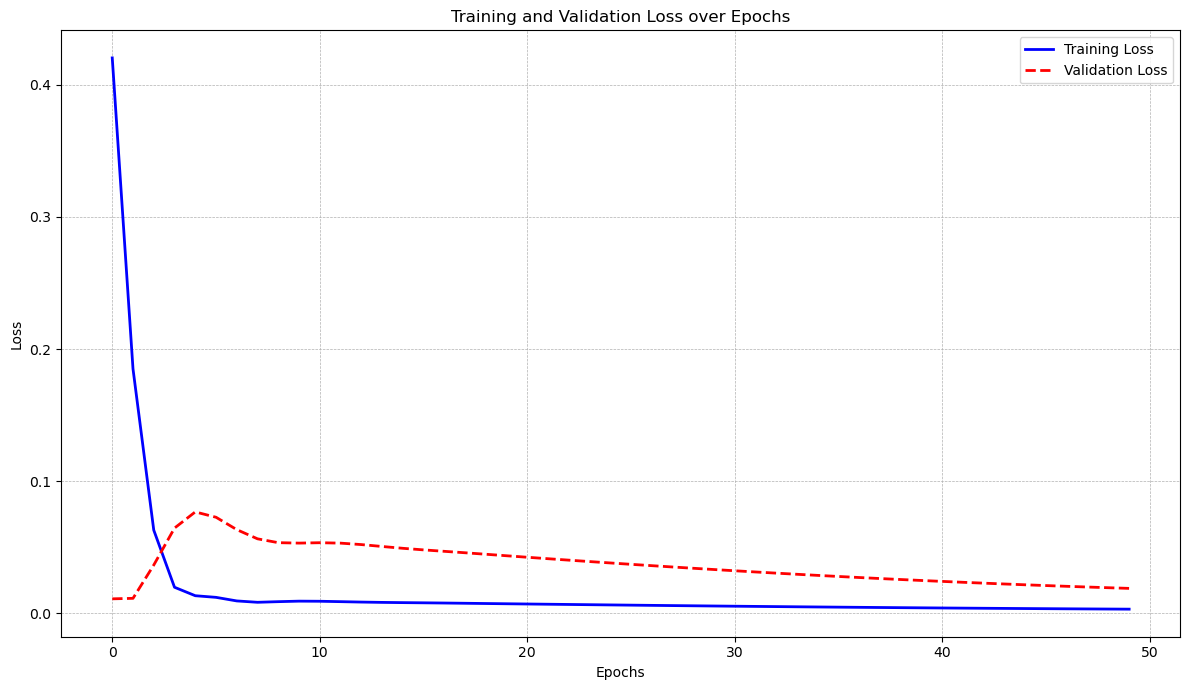

In [18]:
# 'history' is the object returned by model.fit()
plot_training_history(history)

# 2. Actual vs. Predicted Emissions on the Test Set
def plot_actual_vs_predicted(y_test, y_pred):
    # Inverse transform the predictions and actual values to the original scale
    y_pred_original = scaler.inverse_transform(y_pred)
    y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    plt.figure(figsize=(12, 7))
    plt.plot(y_test_original, marker='o', label='Actual', color='blue', linewidth=2)
    plt.plot(y_pred_original, marker='x', label='Predicted', color='red', linestyle='dashed', linewidth=2)
    plt.title('GRU: Actual vs. Predicted Emissions')
    plt.ylabel('Emissions')
    plt.xlabel('Data Points')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

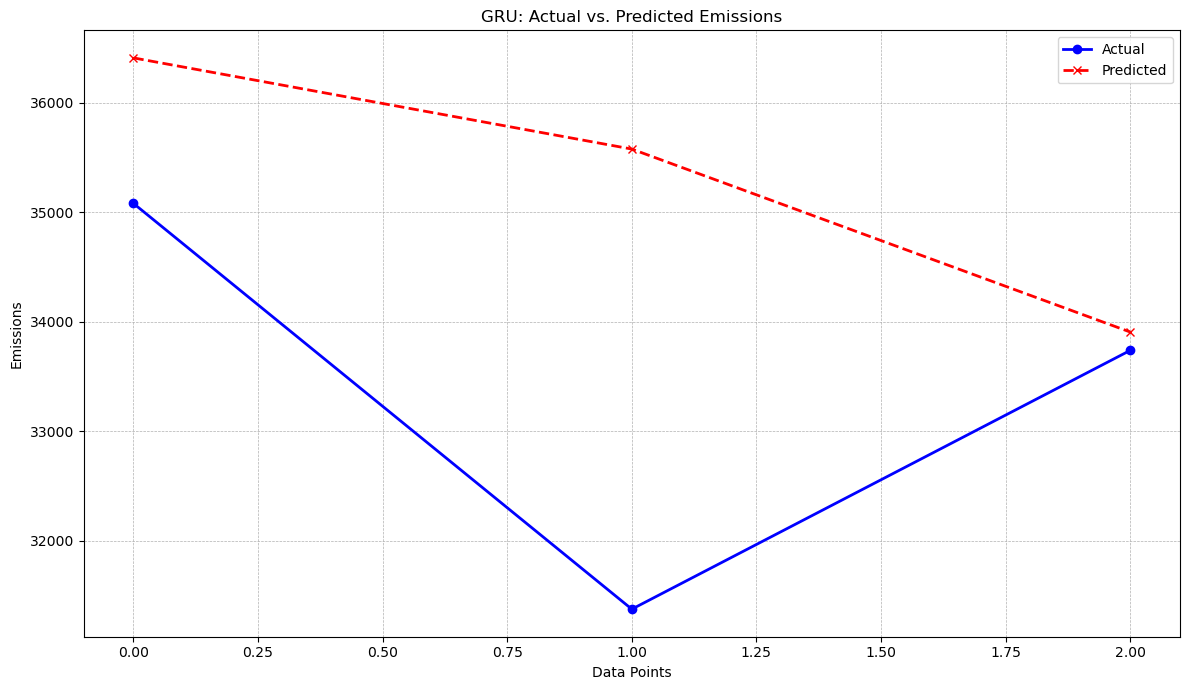

In [19]:
# Assuming 'y_test' are the true values and 'y_pred' are the model's predictions
plot_actual_vs_predicted(y_test, y_pred)

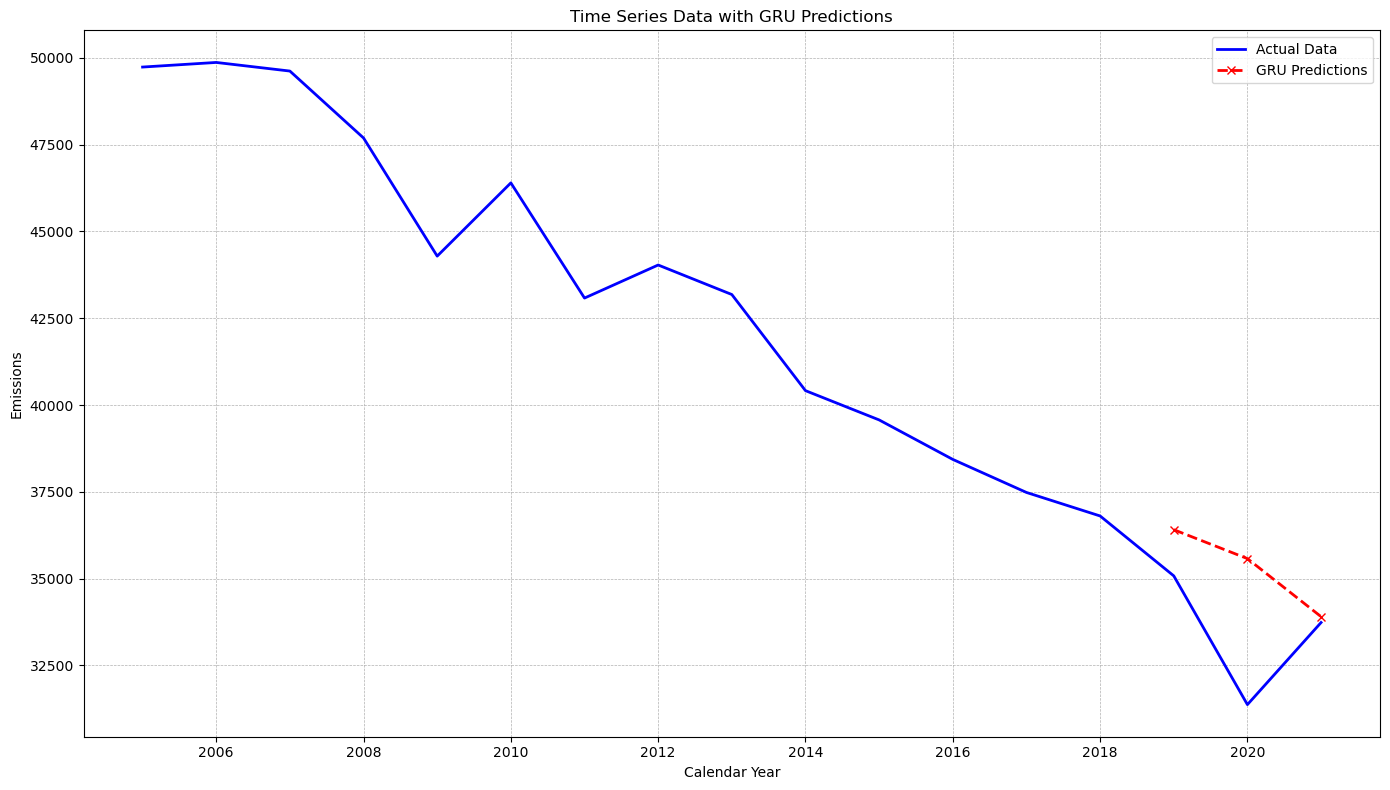

In [20]:
import matplotlib.pyplot as plt

def plot_full_series_with_predictions(data, y_test, y_pred, start_idx):
    """
    Plot the entire time series data and overlay the GRU predictions on the test set.
    
    Parameters:
    - data: The entire time series data.
    - y_test: True values for the test set.
    - y_pred: Predicted values from the model for the test set.
    - start_idx: The index in the data where the test set begins.
    """
    # Inverse transform the predictions and actual values to the original scale
    y_pred_original = scaler.inverse_transform(y_pred)
    y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    plt.figure(figsize=(14, 8))
    
    # Plot the entire data
    plt.plot(data.index, data.values, label='Actual Data', color='blue', linewidth=2)
    
    # Plot the predictions on top of the test set
    predicted_dates = data.index[start_idx:start_idx + len(y_pred)]
    plt.plot(predicted_dates, y_pred_original, marker='x', label='GRU Predictions', color='red', linestyle='dashed', linewidth=2)
    
    plt.title('Time Series Data with GRU Predictions')
    plt.ylabel('Emissions')
    plt.xlabel('Calendar Year')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# As 'grouped_data' is the entire time series data, 'y_test' are the true values, and 'y_pred' are the model's predictions
start_idx_of_test = len(grouped_data) - len(y_test)
plot_full_series_with_predictions(grouped_data, y_test, y_pred, start_idx_of_test)


<h1>Support Vector Regression (SVR) </h1>

In [5]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Initialize the SVR model
svr = SVR(kernel='linear', epsilon=0.1)

# Reshape the data back to 2D for SVR
X_train_2d = X_train.reshape(X_train.shape[0], X_train.shape[2])
X_test_2d = X_test.reshape(X_test.shape[0], X_test.shape[2])

# Train the model
svr.fit(X_train_2d, y_train)

# Predict on the test set
y_pred = svr.predict(X_test_2d)

# Calculate the RMSE on the test set
rmse = mean_squared_error(y_test, y_pred, squared=False)

rmse


0.19679211114050665

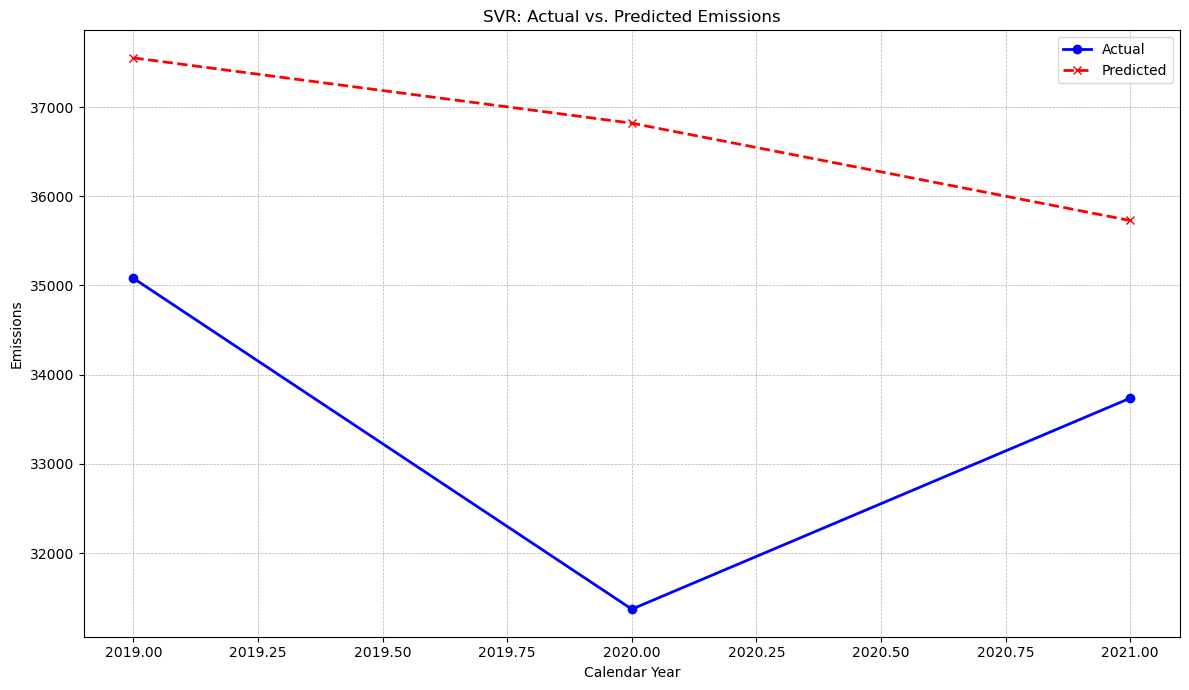

In [6]:
# Inverse transform the predictions and actual values to the original scale
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Plot actual vs predicted values
plt.figure(figsize=(12, 7))
plt.plot(grouped_data.index[-len(y_test_original):], y_test_original, marker='o', label='Actual', color='blue', linewidth=2)
plt.plot(grouped_data.index[-len(y_pred_original):], y_pred_original, marker='x', label='Predicted', color='red', linestyle='dashed', linewidth=2)

plt.title('SVR: Actual vs. Predicted Emissions')
plt.ylabel('Emissions')
plt.xlabel('Calendar Year')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
